## TESS lightcurves

In [21]:
import lightkurve as lk
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import curve_fit
import numpy.polynomial.polynomial as poly

%matplotlib inline

In [748]:
## Query object
hd_target = '200120'
search_result = lk.search_lightcurve('hd %s'%hd_target, mission='TESS',author='*SPOC*')
search_result

#,mission,year,author,exptime,target_name,distance
,,,,s,,arcsec
0,TESS Sector 15,2019,SPOC,120,329947655,0.0
1,TESS Sector 15,2019,TESS-SPOC,1800,329947655,0.0
2,TESS Sector 16,2019,SPOC,120,329947655,0.0
3,TESS Sector 16,2019,TESS-SPOC,1800,329947655,0.0
4,TESS Sector 55,2022,SPOC,120,329947655,0.0
5,TESS Sector 56,2022,SPOC,120,329947655,0.0


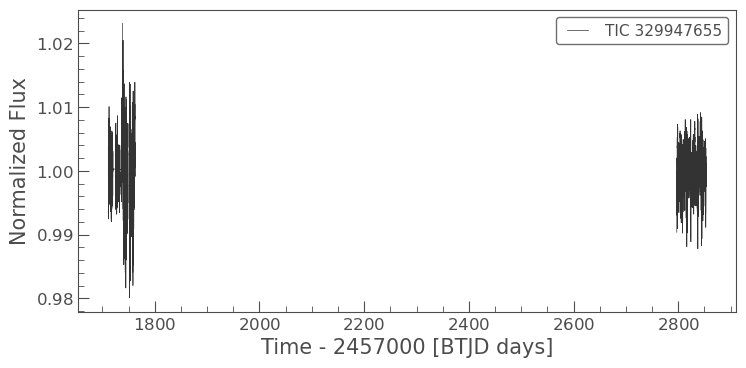

In [749]:
tlc = search_result.download_all().stitch()
#tlc = tlc.remove_outliers()
tlc.plot()
plt.savefig('/Volumes/GoogleDrive/My Drive/ARMADA_final/tess_lcs/HD_%s_tess_lc_raw.pdf'%hd_target)

#### Run below to take out polynomial

In [ ]:
## Remove polynomial
idx = [i for i, arr in enumerate(tlc['flux'].value) if np.isfinite(arr).all()]

coefs = poly.polyfit(tlc['time'].value[idx],tlc['flux'].value[idx], 6)
ffit = poly.polyval(tlc['time'].value, coefs)
tlc.plot()
plt.plot(tlc['time'].value, ffit)

In [ ]:
dt_tlc = tlc.copy()
dt_tlc.flux = dt_tlc.flux / ffit

# Plot the new light curve on top of the original one
ax = tlc.plot(alpha=.5, label='Original');
dt_tlc.plot(ax=ax, label='New');

#### Run below if no polynomial fit

In [750]:
## Run if no polynomial applied:
dt_tlc = tlc.copy()

#### Search for periods

<AxesSubplot:xlabel='Period [$\\mathrm{d}$]', ylabel='BLS Power'>

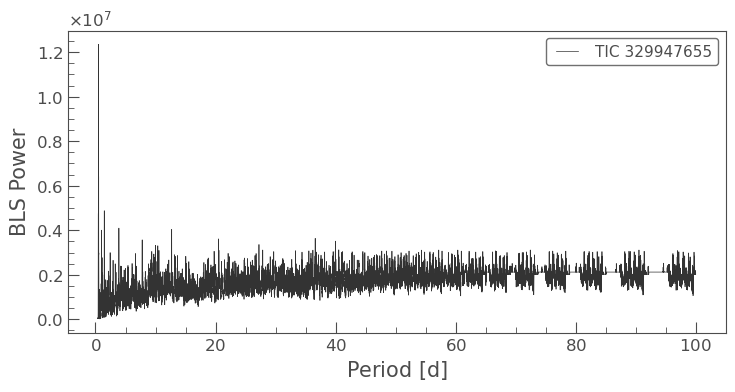

In [751]:
# Create array of periods to search
period = np.linspace(0.4, 100, 10000)
# Create a BLSPeriodogram
bls = dt_tlc.to_periodogram(method='bls', period=period, frequency_factor=1000);
bls.plot()

In [752]:
planet_b_period = bls.period_at_max_power
planet_b_t0 = bls.transit_time_at_max_power
planet_b_dur = bls.duration_at_max_power

# Check the value for period
planet_b_period

<Quantity 0.48964896 d>

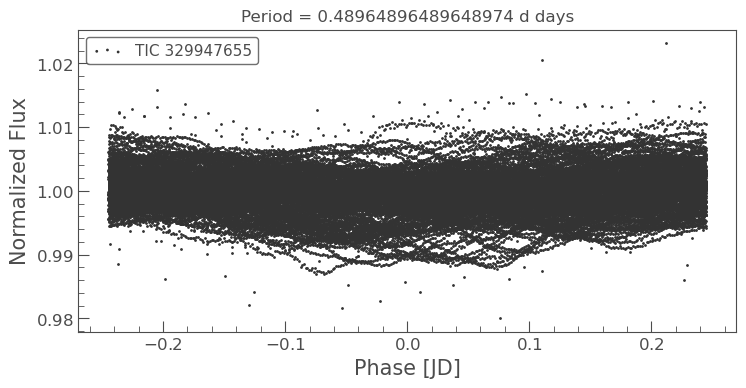

In [753]:
ax = dt_tlc.fold(period=planet_b_period, epoch_time=planet_b_t0).scatter()
ax.set_title('Period = %s days'%planet_b_period)
#ax.set_xlim(-1, 1);
plt.savefig('/Volumes/GoogleDrive/My Drive/ARMADA_final/tess_lcs/HD_%s_tess_lc_folded.pdf'%hd_target)

## Now let's try taking out the sinusoid from variations

In [ ]:
pg = dt_tlc.to_periodogram(maximum_period=5);
pg.plot()

print("period = ", pg.period_at_max_power)

In [ ]:
# Create a model light curve for the highest peak in the periodogram
tlc_model = pg.model(time=dt_tlc.time, frequency=pg.frequency_at_max_power)
# Plot the light curve
ax = dt_tlc.plot()
# Plot the model light curve on top
tlc_model.plot(ax=ax, lw=3, ls='--', c='red')

In [ ]:
new_tlc = dt_tlc.copy()
new_tlc.flux = new_tlc.flux / tlc_model.flux

# Plot the new light curve on top of the original one
ax = dt_tlc.plot(alpha=.5, label='Original');
new_tlc.plot(ax=ax, label='New');

In [ ]:
# Create array of periods to search
period = np.linspace(0.5, 10, 100000)
# Create a BLSPeriodogram
bls = new_tlc.to_periodogram(method='bls', period=period, frequency_factor=1000);
bls.plot()

In [ ]:
planet_b_period = bls.period_at_max_power
planet_b_t0 = bls.transit_time_at_max_power
planet_b_dur = bls.duration_at_max_power

# Check the value for period
planet_b_period

In [ ]:
ax = new_tlc.fold(period=planet_b_period, epoch_time=planet_b_t0 + planet_b_period/4).scatter()
#ax.set_xlim(-1, 1);